# Page Rank

## Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
from copy import deepcopy
import pickle

## EdgeList class

In [49]:
def  Normalize2P(P, P0, n, norm_1):
    '''
        This function Normalize the vector P for the 
        PageRank algorithm.
        Inputs:
            - P: vector coded as a dict with size n.
            - P0: vector coded as a dict for the Rooted 
            PageRank.
            - n: number of nodes.
            - norm_1: the norm 1 of the vector P.
        Outputs:
            - Pout: vector coded as a dict which is the 
            normalized vector of P.
    '''
    if P0 == None:
        for u in P:
            P[u] += (1 - norm_1) / n
    else:
        for u in P0:
            P[u] += P0[u] * (1 - norm_1)
    return P

In [50]:
class EdgeList:
  '''
  Class to model a graph using edgelist structure.
  This model used for the PageRank algorithm.
  '''
  def read_file_name(self, file_name):
    '''
      Read the names of nodes .
      Input:
        - file_name: file to read the node name pair.
      Add these attributes:
        - names: dict for each node it's name.
        - nodes: list of nodes in the graph.
        - n: number of nodes.
    '''
    self.names = {}
    self.nodes = []
    with(open(file_name, 'r')) as f:
      line = f.readline()
      while line:
        line = line.split()
        if len(line) != 0 and line[0] != "#":
          u = int(line[0])
          self.nodes.append(u)
          self.names[u] = " ".join(line[1:])
        line = f.readline()
    f.close()
    self.n = len(self.nodes)

  def read_file_edglist(self, file_name):
    '''
      Read a graph from file and store it as edgelist
      Input:
        - file_name: file to read the graph from.
      Add these attributes:
        - n: number of nodes.
        - m: number of edges.
        - edgelist: a dict with keys the nodes and values
                    list of neighbors.
        - deg_out: dict with keys the nodes
                  and value the out degree.
        - deg_in: dict with keys the nodes
                  and value the in degree.
    '''
    self.m = 0
    self.edgelist ={}
    with(open(file_name, 'r')) as f:
      line = f.readline()
      while line:
        line = line.split()
        if len(line) == 2:
          u = int(line[0])
          v = int(line[1])
          self.m += 1
          if not(u in self.edgelist.keys()):
            self.edgelist[u] = []
          self.edgelist[u].append(v)            
        line = f.readline()
    f.close()
    self.deg_out = {}
    self.deg_in = {}
    for u in self.nodes:
      self.deg_in[u] = 0
      if u in self.edgelist.keys():
        self.deg_out[u] = len(self.edgelist[u])
      else:
        self.deg_out[u] = 0
    for u, neighbors in self.edgelist.items():
      for v in neighbors:
        self.deg_in[v] +=1

  def __init__(self, file_names, file_graph):
    self.read_file_name(file_names)
    self.read_file_edglist(file_graph)
    self.reverse_edgelist()
    self.get_end_nodes()

  def edge_exists(self, u, v):
    '''
     Return if there's an edge from u to v.
     Input:
      - edgelist: a graph stored as edgelist
      - u: starting node.
      - v: ending node.
    Output:
      - Boolean if u lead to v.
    '''
    return v in self.edgelist[u]
  
  def reverse_edgelist(self):
    '''
    This function compute the pagerank algorithm based on the power iteration method.
      Inputs:
          - n: number of nodes.
          - m: number of edges.
          - edgelist: a dict with keys the nodes and values
                      list of neighbors.
          - nodes: list of nodes.
        Add this attribute:
        - reverse_edgelist: a dict with keys the nodes and values
                      list of nodes that lead to the node.
    '''
    self.reverse_edgelist = {}
    for u in self.nodes:
      if not u in self.reverse_edgelist.keys():
        self.reverse_edgelist[u] = []
      if not u in self.edgelist.keys():
        continue
      for v in self.edgelist[u]:
        if not (v in self.reverse_edgelist.keys()):
          self.reverse_edgelist[v] = []
        self.reverse_edgelist[v].append(u)

  def get_end_nodes(self):
    '''
      This function compute the pagerank algorithm based on the power iteration method.
      Inputs:
          - edgelist: a dict with keys the nodes and values
                      list of neighbors.
          - nodes: list of nodes.
          - deg_out: dict contains the out degree of every node.
        Add this attribute:
        - end_nodes: a list of nodes that have an out degree equal to 0.
    '''
    self.end_nodes = []
    for u in self.nodes:
      if self.deg_out[u] == 0:
        self.end_nodes.append(u)
  def PageRank(self, alpha= 0.1, t= 100, epsilion= 1e-3, P0= None):
    '''
     This method compute the pagerank algorithm based on the power iteration 
     method.
     Inputs:
        - alpha: damping factor, between 0 and 1.
        - t: number of iterations to be done.
        - epsilion: the limit of convergence of the graph.
        - P0: node for the rooted pagerank.
              If not initialized the regular pagerank will be used. 
     Output:
      - P:  dict of Pageranks with size n (number of node).
      - history: dict containing the different values for each iterations.
      - total_time: the time needed to finsih all iterations/converge.
    '''
    P = {u:1/self.n for u in self.nodes}
    Pt = {u:0 for u in self.nodes}
    start_time = time.time()
    history = {}
    for i in range(t):
        iter_time = time.time()
        norm1 = np.sum([abs(P[u]) for u in self.end_nodes]) / self.n
        end_inter = np.sum([P[u] for u in self.end_nodes]) / self.n
        for v in tqdm(self.nodes):
            inter = end_inter + np.sum([P[u]/self.deg_out[u] for u in self.reverse_edgelist[v]])
            if P0 == None:
                Pt[v] = (1 - alpha) * inter + alpha /self.n
            elif v in P0.keys():
                Pt[v] = (1 - alpha) * inter + alpha * P0[v]
            else:
                Pt[v] = (1 - alpha) * inter
            norm1 += abs(Pt[v]) # compute the norm 1
        Pt = Normalize2P(Pt, P0, self.n, norm1)
        diff = np.sum([abs(Pt[u] - P[u]) for u in self.nodes])
        P = deepcopy(Pt)
        history[i] = {}
        history[i]["norm"] = norm1
        history[i]["diff"] = diff
        history[i]["time"] = time.time() - iter_time
        if diff < epsilion:
            break
    total_time = time.time() - start_time
    return P, history, total_time

In [7]:
path = "/content/drive/MyDrive/sod"
file_name_edge = path + "/alr21--dirLinks--enwiki-20071018.txt"
file_name_names = path + "/alr21--pageNum2Name--enwiki-20071018.txt"

In [51]:
G = EdgeList(file_name_names, file_name_edge)

In [9]:
alpha = 0.15 
t = 20
eps = 1e-3
P, history, total_time = G.PageRank(alpha= alpha, t= t, epsilion= eps)

In [10]:
print(" the totak amount of time needed for the PagRank to converge", total_time / 60, ' in minutes.')

 the totak amount of time needed for the PagRank to converge 24.450939321517943  in minutes.


We can see that after 12 iterations the $|| P_{t+1} - P_{t}||_1 
< \epsilon$ with $\epsilon = 0.001$

In [11]:
history = pd.DataFrame.from_dict(history)
history = history.transpose()
history = history.reset_index()
history = history.rename(columns= {"index": "iteration"})
history.head()

,iteration,norm,diff,time
0,0,1.0,1.172459,86.196984
1,1,1.0,0.386784,110.635465
2,2,1.0,0.117577,116.351637
3,3,1.0,0.048183,121.932366
4,4,1.0,0.025073,114.413910


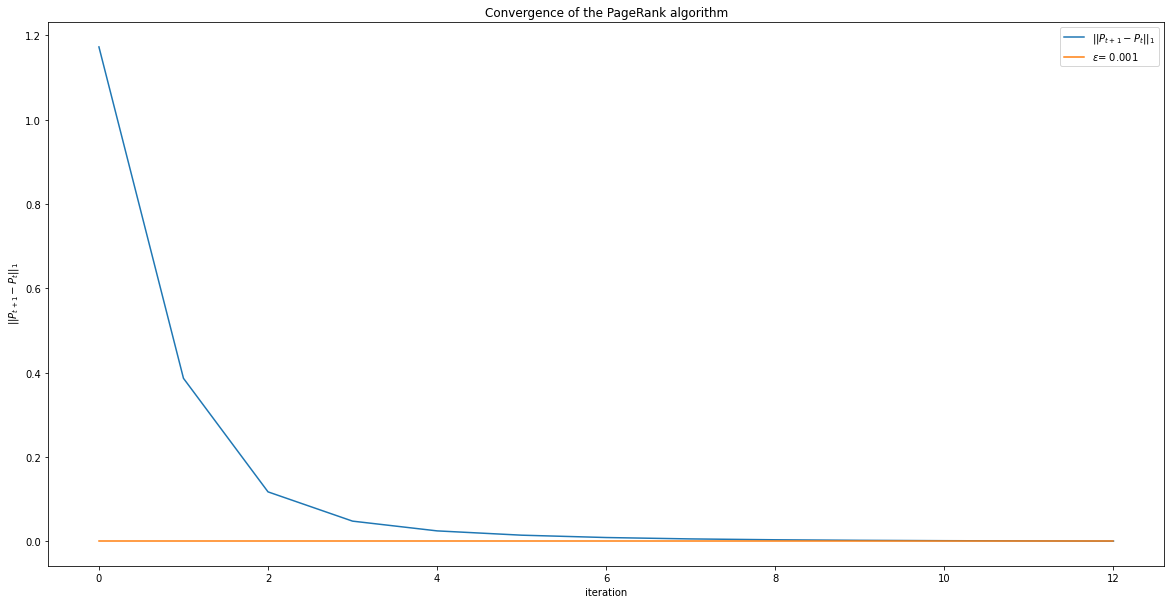

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= history, y="diff", x="iteration", label= "$|| P_{t+1} - P_{t} ||_1$")
plt.plot([eps for i in range(history.shape[0])], label= "$\epsilon$= "+ str(eps))
plt.title("Convergence of the PageRank algorithm")
plt.xlabel("iteration")
plt.ylabel(" $|| P_{t+1} - P_{t} ||_1$")
plt.legend()
plt.show()

No handles with labels found to put in legend.


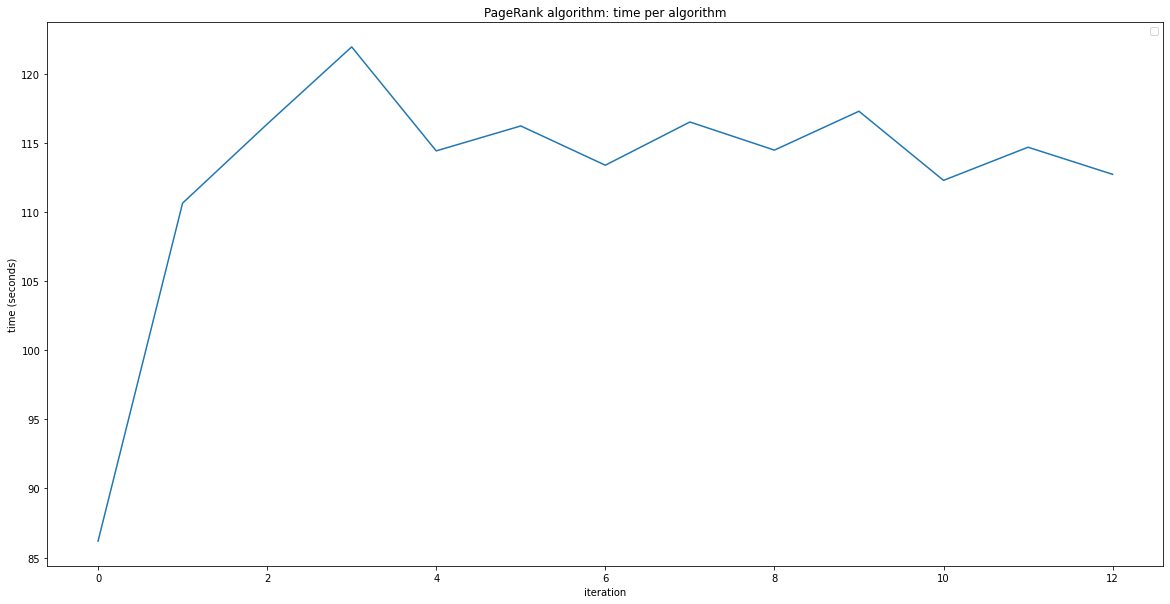

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= history, y="time", x="iteration")
plt.title("PageRank algorithm: time per algorithm")
plt.xlabel("iteration")
plt.ylabel("time (seconds)")
plt.legend()
plt.show()

#### Top 5 pages

In [14]:
Values = sorted(list(P.values()), reverse= True)
Val5 = Values[:5]
Top5 = []
Top5id = []
values5 = []
for val in Val5:
  for u, valeur in P.items():
    if valeur == val:
      Top5.append(G.names[u])
      Top5id.append(u)
      values5.append(valeur)
      break
TOP = pd.DataFrame([Top5, Top5id, values5])
print("Top5: ", Top5)
print("Top5id: ", Top5id)
print("Values5: ", values5)
TOP = TOP.transpose().rename(columns={0: "name",
                                      1: "ID",
                                      2: "PageRank"})
TOP

Top5:  ['United States', 'United Kingdom', 'Germany', '2007', '2006']
Top5id:  [3434750, 31717, 11867, 36165, 36164]
Values5:  [0.003636667608790408, 0.0015913587870100168, 0.0013627250448507826, 0.0013610452966175827, 0.001357178004772237]


,name,ID,PageRank
0,United States,3434750,0.00363667
1,United Kingdom,31717,0.00159136
2,Germany,11867,0.00136273
3,2007,36165,0.00136105
4,2006,36164,0.00135718


#### low 5 pages

In [15]:
Val5 = Values[-1]
Low5 = []
Low5id = []
for u, val in P.items():
  if val == Val5:
    Low5.append(G.names[u])
    Low5id.append(u)
LOW = pd.DataFrame([Low5[0:5], Low5id[0:5], [Val5 for i in range(5)]])
print("Low5: ", Low5[0:5])
print("Low5id: ", Low5id[0:5])
LOW = LOW.transpose().rename(columns={0: "name",
                                      1: "ID",
                                      2: "PageRank"})
LOW

Low5:  ['Aberdeen (disambiguation)', 'Animal (disambiguation)', 'Antigua and Barbuda', 'AWK (disambiguation)', 'Demographics of American Samoa']
Low5id:  [632, 679, 951, 964, 1110]


,name,ID,PageRank
0,Aberdeen (disambiguation),632,7.3057e-08
1,Animal (disambiguation),679,7.3057e-08
2,Antigua and Barbuda,951,7.3057e-08
3,AWK (disambiguation),964,7.3057e-08
4,Demographics of American Samoa,1110,7.3057e-08


## Exercice 2

In [16]:
P1, history1, total_time1 = G.PageRank(alpha= 0.1, t= 20)

In [17]:
P2, history2, total_time2 = G.PageRank(alpha= 0.2, t= 20)

In [18]:
P3, history3, total_time3 = G.PageRank(alpha= 0.5, t= 20)

In [20]:
P4, history4, total_time4 = G.PageRank(alpha= 0.9, t= 20)

In [21]:
data = pd.DataFrame.from_dict(G.deg_in, orient= "index", columns= ["in-degree"])
data = data.join(pd.DataFrame.from_dict(G.deg_out, orient= "index", columns= ["out-degree"]))
data = data.join(pd.DataFrame.from_dict(G.names, orient= "index", columns= ["name"]))
data = data.join(pd.DataFrame.from_dict(P, orient= "index", columns= ["PageRank"]))
data = data.join(pd.DataFrame.from_dict(P1, orient= "index", columns= ["PageRank0.1"]))
data = data.join(pd.DataFrame.from_dict(P2, orient= "index", columns= ["PageRank0.2"]))
data = data.join(pd.DataFrame.from_dict(P3, orient= "index", columns= ["PageRank0.5"]))
data = data.join(pd.DataFrame.from_dict(P4, orient= "index", columns= ["PageRank0.9"]))
data = data.reset_index()
data = data.rename(columns= {"index": "ID"})
data

,ID,in-degree,out-degree,name,PageRank,PageRank0.1,PageRank0.2,PageRank0.5,PageRank0.9
0,12,1939,286,Anarchism,4.600589e-05,5.079024e-05,4.165788e-05,2.235413e-05,4.590849e-06
1,25,808,185,Autism,1.367837e-05,1.449204e-05,1.298774e-05,9.307273e-06,2.628100e-06
2,39,551,73,Albedo,1.346570e-05,1.437929e-05,1.268547e-05,8.635093e-06,2.324242e-06
3,43,697,97,Abu Dhabi,8.914808e-06,9.118096e-06,8.652204e-06,6.348728e-06,1.850615e-06
4,290,198,57,A,5.554413e-06,6.771186e-06,4.645490e-06,1.995847e-06,7.077295e-07
...,...,...,...,...,...,...,...,...,...
2080365,13834615,0,0,Los Time,7.305697e-08,4.883452e-08,9.725061e-08,2.418305e-07,4.331188e-07
2080366,13834629,0,31,Jon Cole,7.305697e-08,4.883452e-08,9.725061e-08,2.418305e-07,4.331188e-07
2080367,13834635,0,5,Salt of aspartame-acesulfame,7.305697e-08,4.883452e-08,9.725061e-08,2.418305e-07,4.331188e-07
2080368,13834636,0,0,Stefan Gaulin,7.305697e-08,4.883452e-08,9.725061e-08,2.418305e-07,4.331188e-07


In [63]:
del P, P1, P2, P3, P4

In [22]:
save_data = True

In [40]:
if save_data == True:
    file_data = path + "/data_ex2.pkl"
    with open(path+file_data, 'wb') as f:
        pickle.dump(data, f)
    f.close()

FileNotFoundError: ignored

In [ ]:
load_data = False

In [ ]:
if load_data == True:
    file_data = path + "/data_sim.pkl"
    with open(path+file_data, 'rb') as f:
        data = pickle.load(f)
    f.close()

#### PageRank VS in-degree

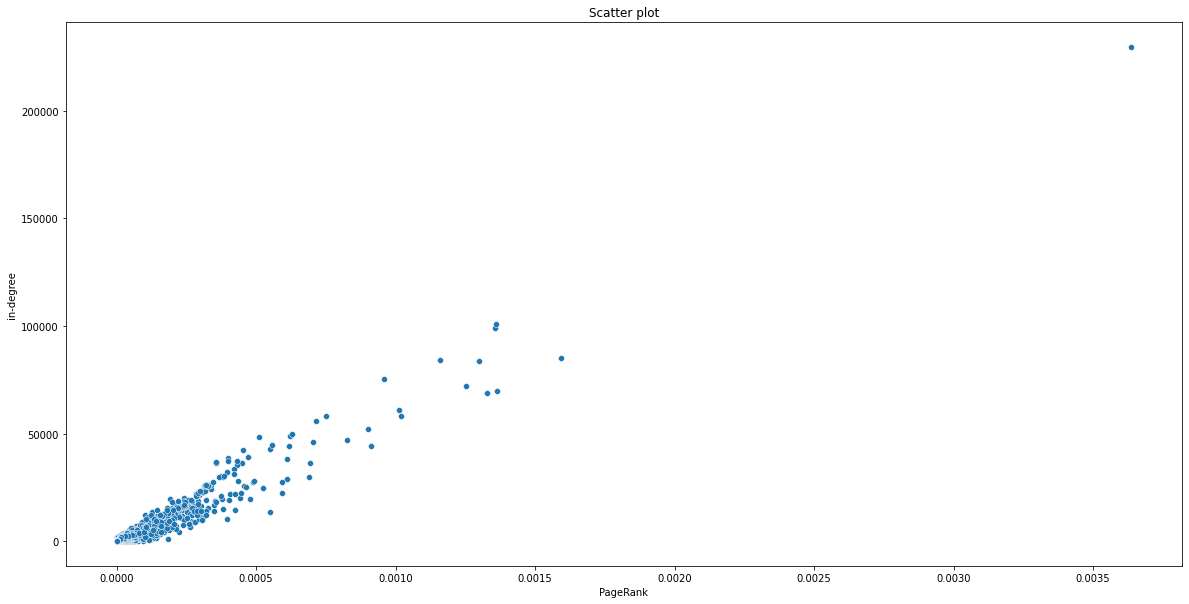

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="in-degree")
plt.title("Scatter plot")
plt.show()

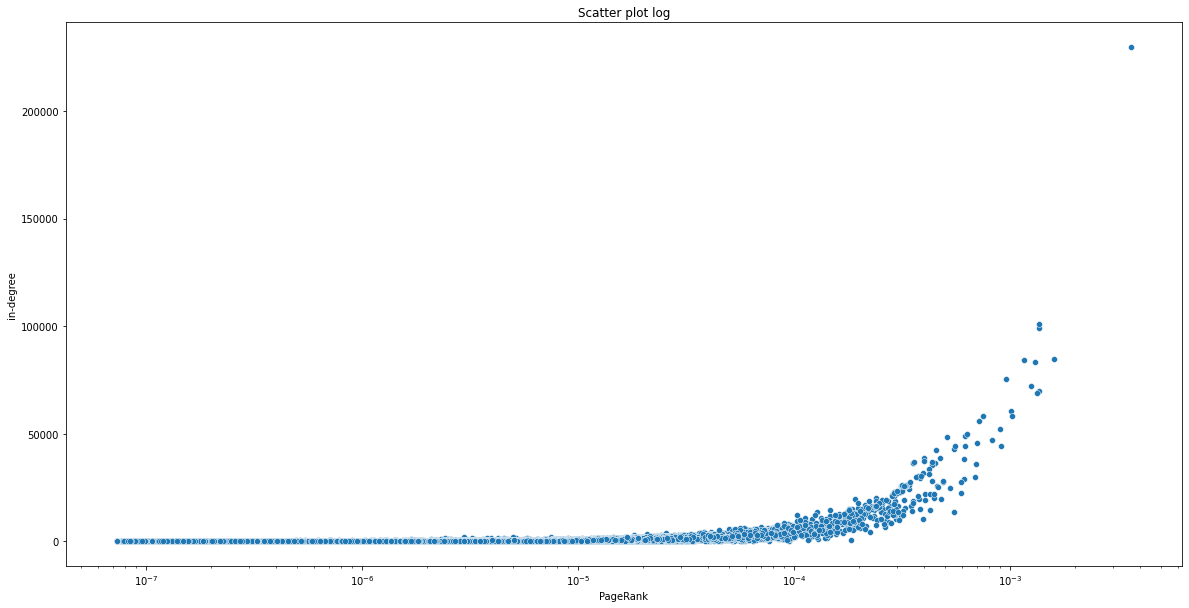

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="in-degree")
ax.set_xscale('log')
plt.xlabel("Page Rank $\alpha$ = 0.15")
plt.ylabel("In-degree")
plt.title("Scatter plot log")
plt.show()

#### PageRank VS out-degree

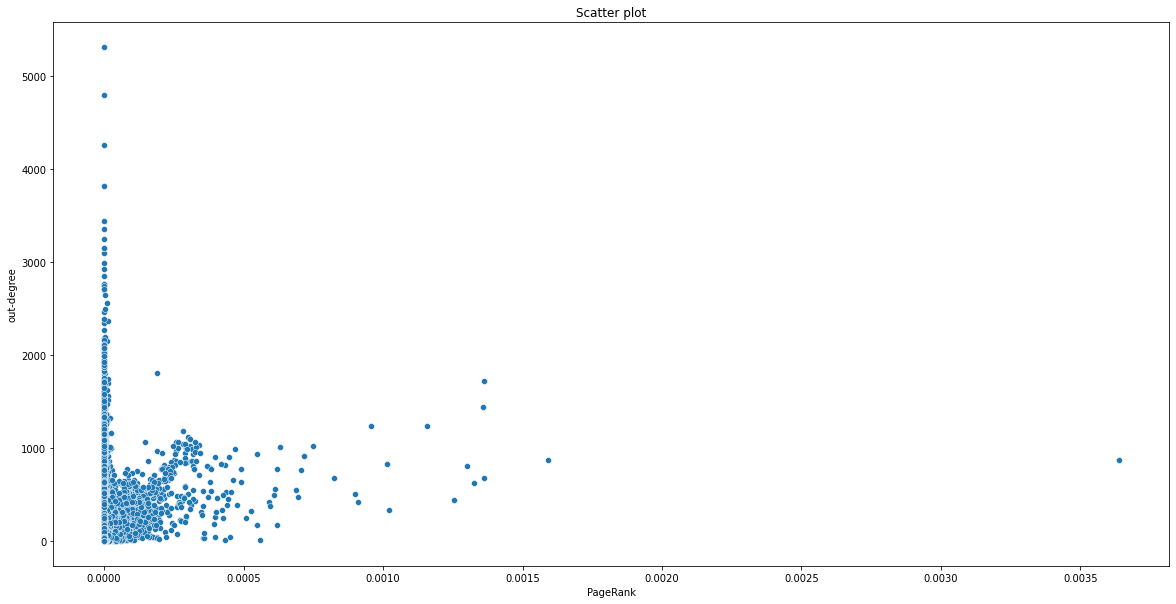

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="out-degree")
# plt.xticks(rotation = 45)
plt.title("Scatter plot")
plt.show()

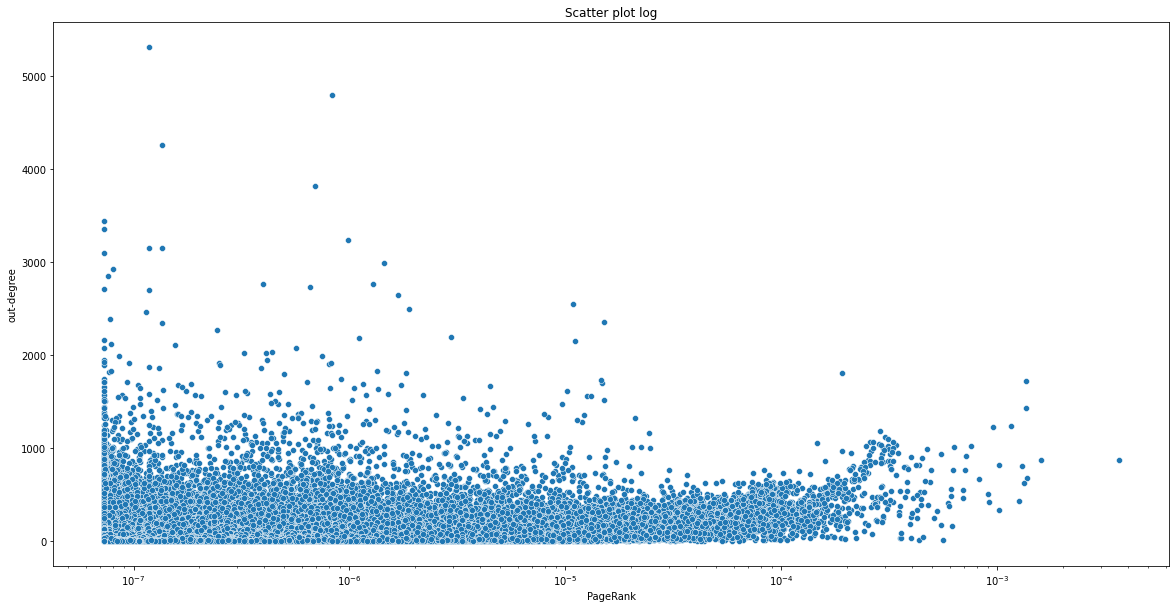

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="out-degree")
ax.set_xscale('log')
plt.xlabel("Page Rank $\alpha$ = 0.15")
plt.ylabel("Out-degree")
plt.title("Scatter plot log")
plt.show()

#### PageRank0.15 VS PageRank0.1

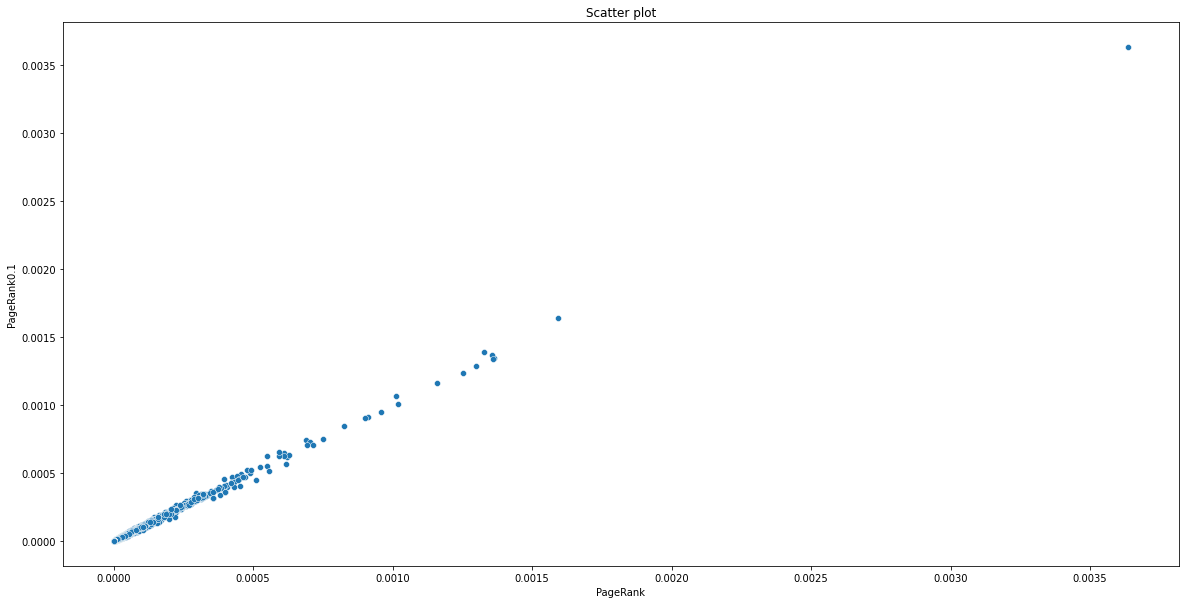

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.1")
# plt.xticks(rotation = 45)
plt.title("Scatter plot")
plt.show()

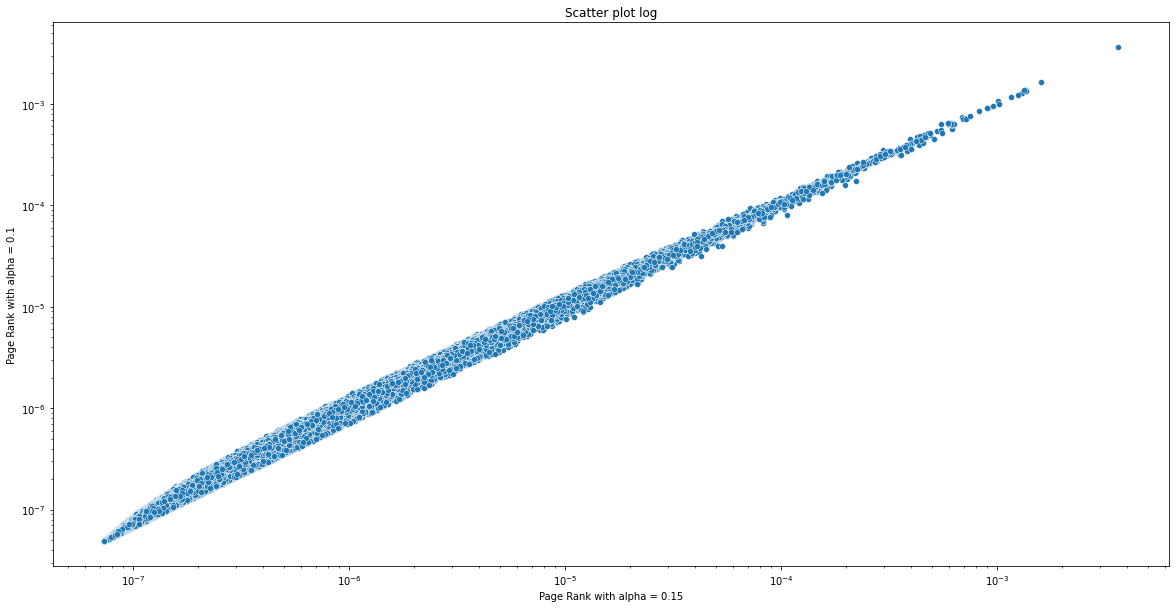

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.1")
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Page Rank with alpha = 0.15")
plt.ylabel("Page Rank with alpha = 0.1")
plt.title("Scatter plot log")
plt.show()

#### PageRank0.15 VS PageRank0.2

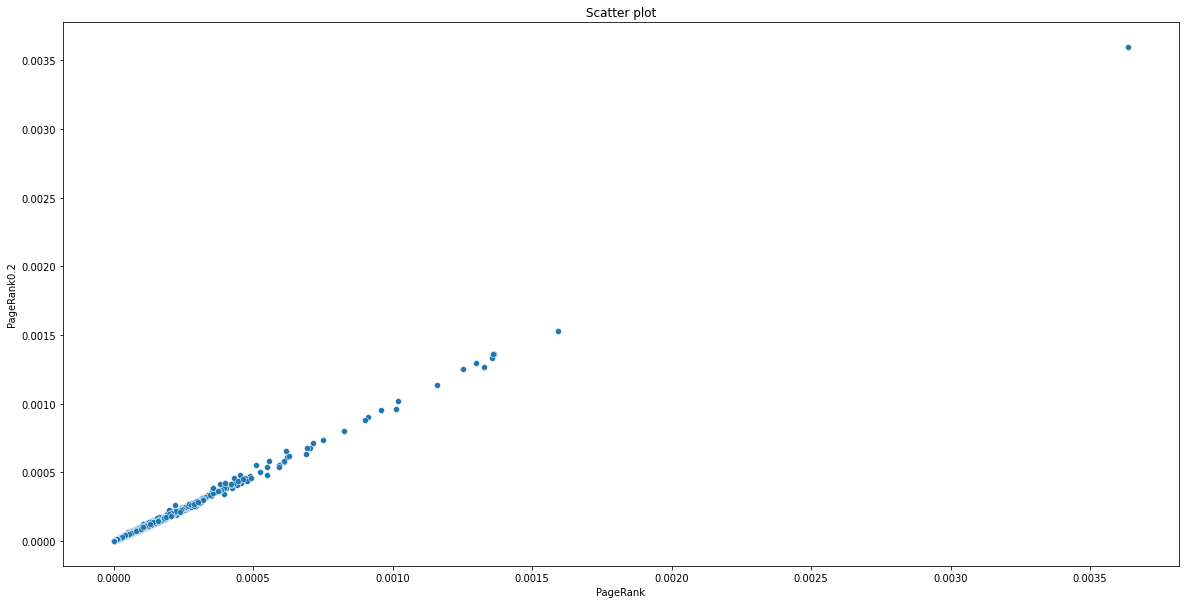

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.2")
# plt.xticks(rotation = 45)
plt.title("Scatter plot")
plt.show()

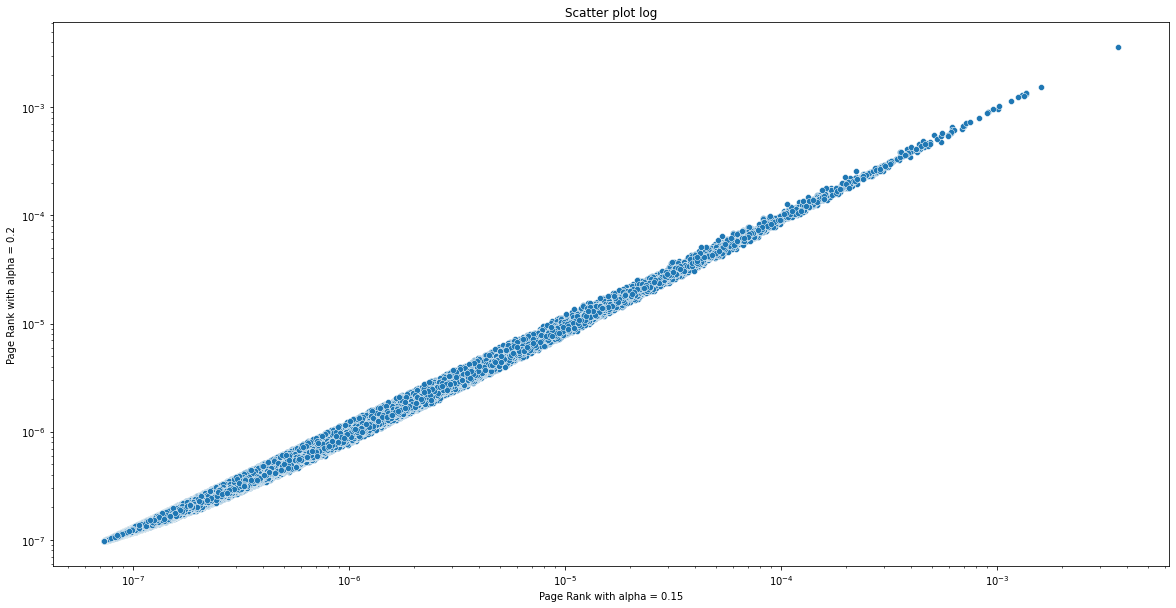

In [65]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.2")
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Page Rank with alpha = 0.15")
plt.ylabel("Page Rank with alpha = 0.2")
plt.title("Scatter plot log")
plt.show()

#### PageRank0.15 VS PageRank0.5

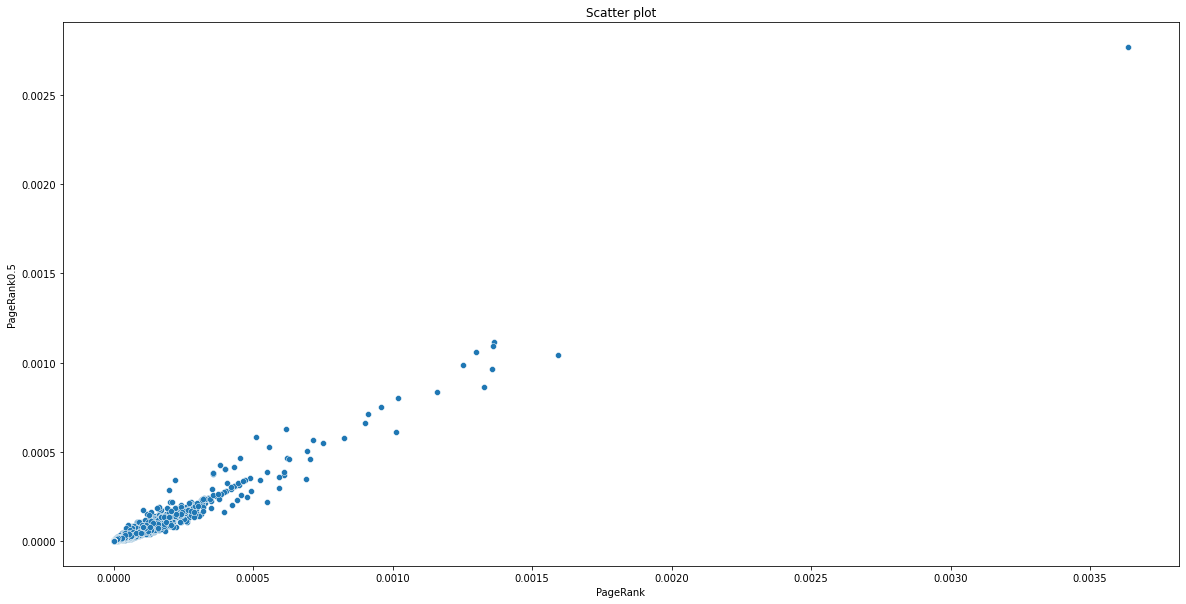

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.5")
# plt.xticks(rotation = 45)
plt.title("Scatter plot")
plt.show()

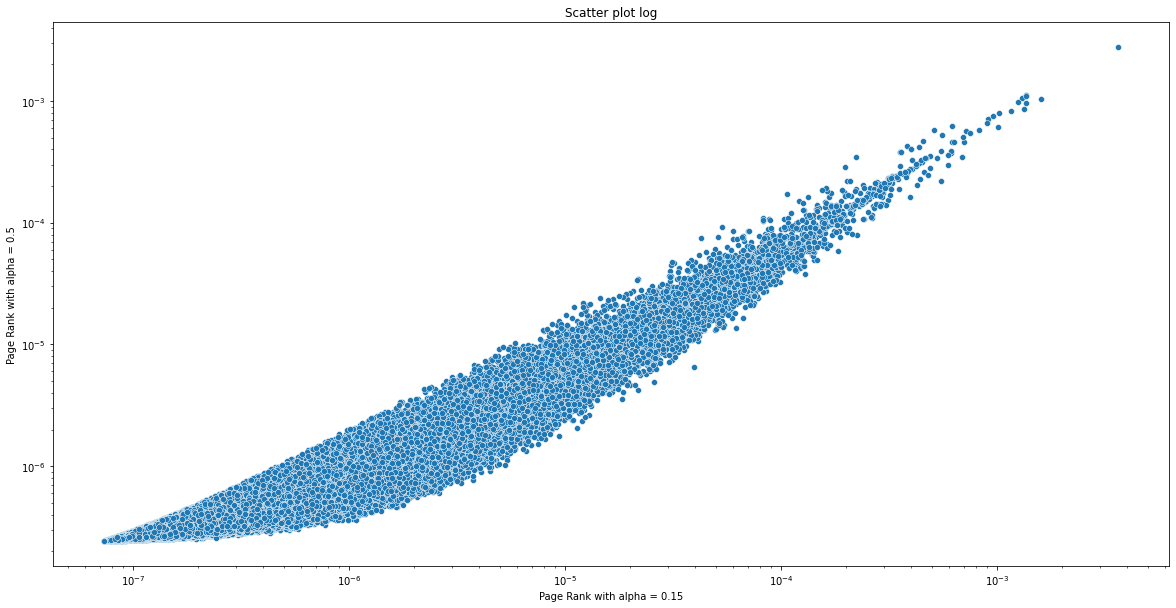

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.5")
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Page Rank with alpha = 0.15")
plt.ylabel("Page Rank with alpha = 0.5")
plt.title("Scatter plot log")
plt.show()

#### PageRank0.15 VS PageRank0.9

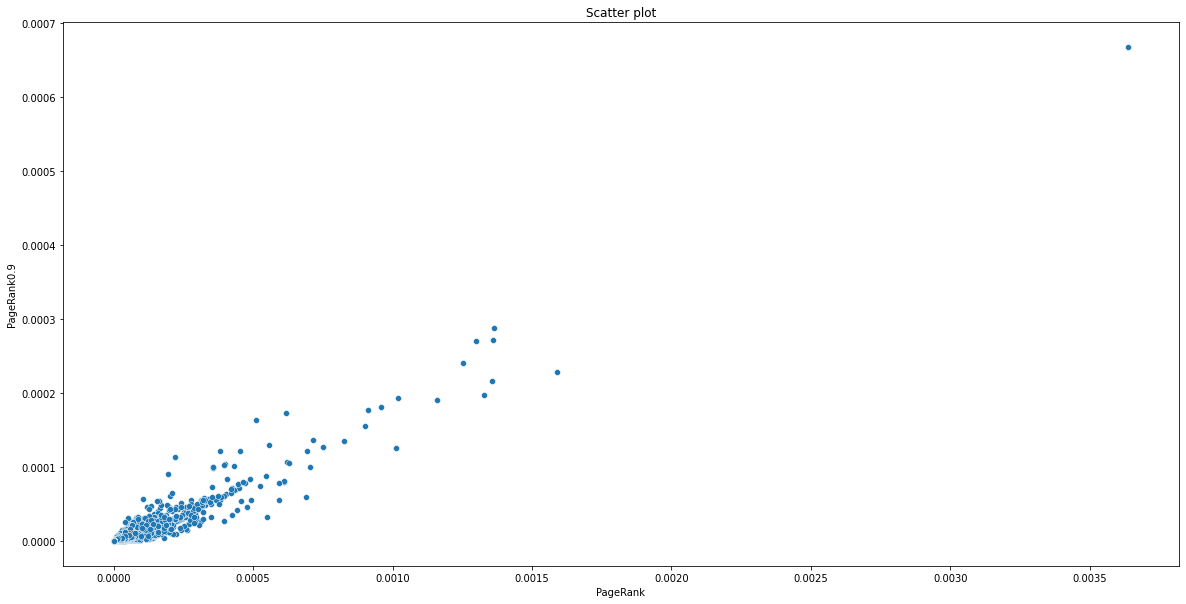

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.9")
plt.xticks(rotation = 45)
plt.title("Scatter plot")
plt.show()

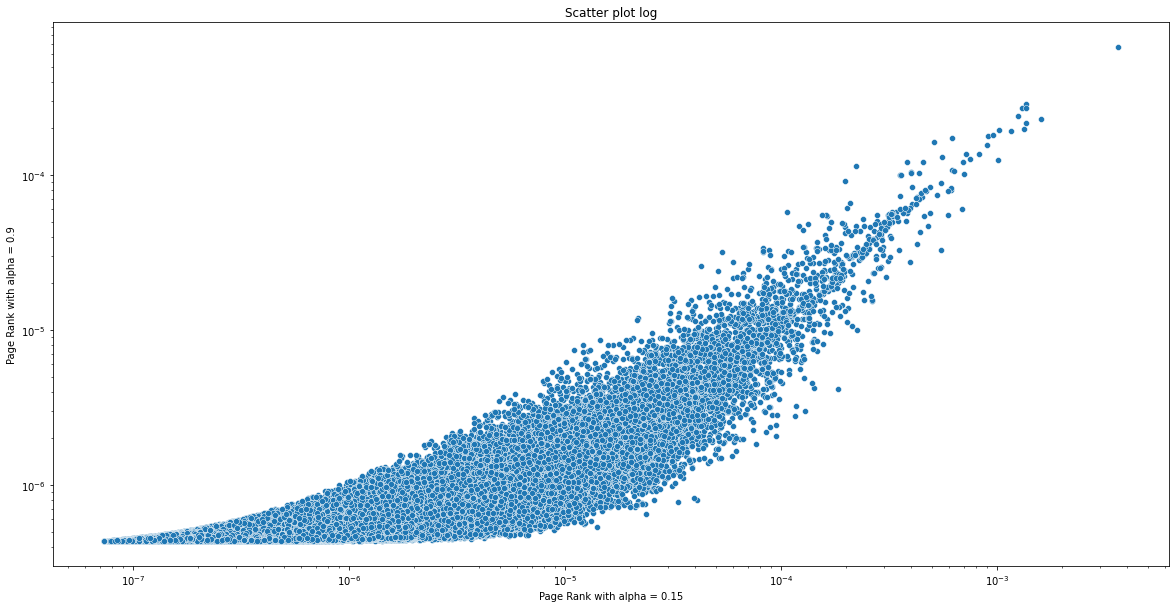

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data= data, x="PageRank", y="PageRank0.9")
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Page Rank with alpha = 0.15")
plt.ylabel("Page Rank with alpha = 0.9")
plt.title("Scatter plot log")
plt.show()

### Correlation matrix

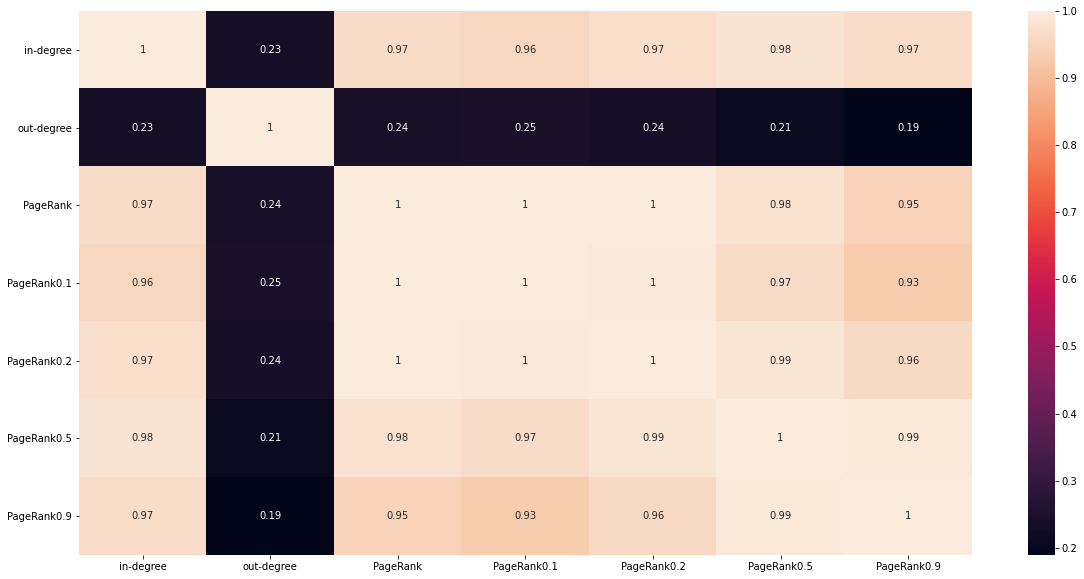

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
corrMatrix = data.drop(columns="ID").corr()
sns.heatmap(corrMatrix, annot=True)
plt.yticks(rotation = 0)
plt.show()

In [42]:
data[data["ID"] == 3434750 ]

,ID,in-degree,out-degree,name,PageRank,PageRank0.1,PageRank0.2,PageRank0.5,PageRank0.9
837630,3434750,229735,873,United States,0.003637,0.00363,0.003597,0.00277,0.000668


## Exercice 3 

In [43]:
data[data["name"] == "Magnus Carlsen"]

,ID,in-degree,out-degree,name,PageRank,PageRank0.1,PageRank0.2,PageRank0.5,PageRank0.9
193431,442682,33,80,Magnus Carlsen,8.942004e-07,9.095836e-07,8.706873e-07,6.839344e-07,5.016314e-07


In [47]:
u = data.loc[data["name"] == "Magnus Carlsen"]["ID"].item()
P0 = {node:0 for node in G.nodes}
P0[u] = 1
alpha = 0.15
t = 10
eps = 0

In [55]:
PMC, historyMC, total_timeMC = G.PageRank(alpha= alpha, t= t, epsilion= eps, P0= P0)

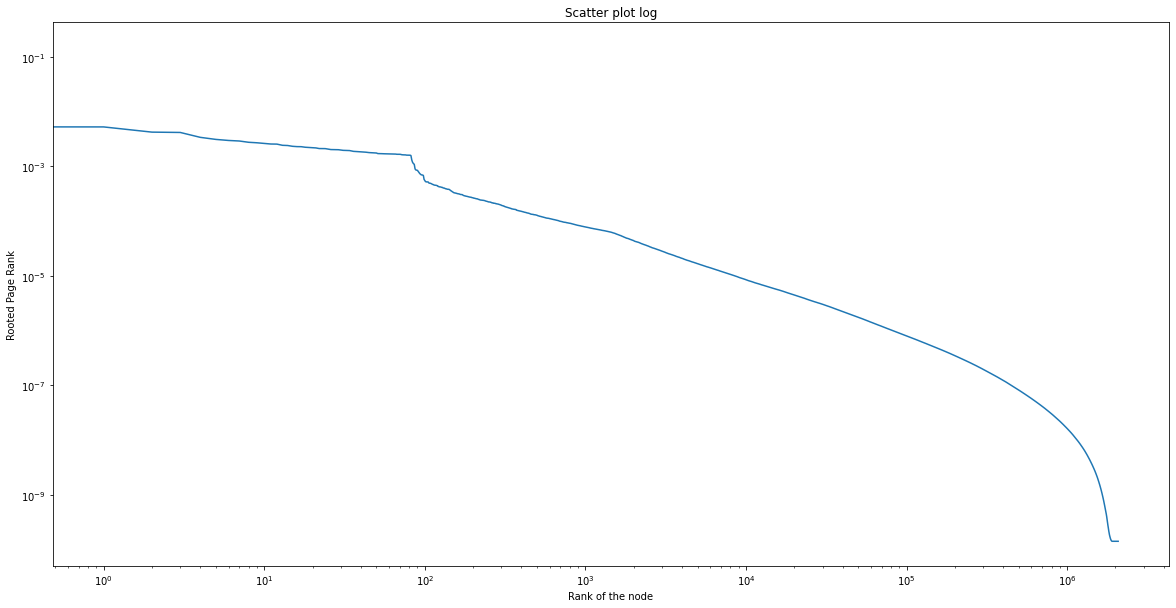

In [86]:
dataPMC = pd.DataFrame.from_dict(PMC, orient= "index", columns= ["RootedPageRank"])
dataPMC.sort_values(by=['RootedPageRank'], inplace= True, ascending= False)
dataPMC = dataPMC.reset_index()
dataPMC.drop(columns=["index"], inplace= True)
dataPMC.reset_index(inplace= True)
dataPMC.rename(columns= {"index": "ID"}, inplace= True)
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= dataPMC, x="ID", y="RootedPageRank")
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Rank of the node")
plt.ylabel("Rooted Page Rank")
plt.title("Scatter plot log")
plt.show()

In [61]:
Values = sorted(list(PMC.values()), reverse= True)
Val5 = Values[:5]
Top5 = []
Top5id = []
values5 = []
for val in Val5:
  for u, valeur in PMC.items():
    if valeur == val:
      Top5.append(G.names[u])
      Top5id.append(u)
      values5.append(valeur)
      break
TOP = pd.DataFrame([Top5, Top5id, values5])
print("Top5: ", Top5)
print("Top5id: ", Top5id)
print("Values5: ", values5)
TOP = TOP.transpose().rename(columns={0: "name",
                                      1: "ID",
                                      2: "PageRank"})
TOP

Top5:  ['Magnus Carlsen', 'Chess', 'Grandmaster (chess)', 'Fédération Internationale des Échecs', 'Elo rating system']
Top5id:  [442682, 5134, 12304, 11146, 70421]
Values5:  [0.15061395561872923, 0.005257310186526878, 0.004223448117633293, 0.004165602184792605, 0.0033909131783959085]


,name,ID,PageRank
0,Magnus Carlsen,442682,0.150614
1,Chess,5134,0.00525731
2,Grandmaster (chess),12304,0.00422345
3,Fédération Internationale des Échecs,11146,0.0041656
4,Elo rating system,70421,0.00339091


In [62]:
Val5 = Values[-1]
Low5 = []
Low5id = []
for u, val in PMC.items():
  if val == Val5:
    Low5.append(G.names[u])
    Low5id.append(u)
LOW = pd.DataFrame([Low5[0:5], Low5id[0:5], [Val5 for i in range(5)]])
print("Low5: ", Low5[0:5])
print("Low5id: ", Low5id[0:5])
LOW = LOW.transpose().rename(columns={0: "name",
                                      1: "ID",
                                      2: "PageRank"})
LOW

Low5:  ['Aberdeen (disambiguation)', 'Animal (disambiguation)', 'Antigua and Barbuda', 'AWK (disambiguation)', 'Demographics of American Samoa']
Low5id:  [632, 679, 951, 964, 1110]


,name,ID,PageRank
0,Aberdeen (disambiguation),632,1.43037e-10
1,Animal (disambiguation),679,1.43037e-10
2,Antigua and Barbuda,951,1.43037e-10
3,AWK (disambiguation),964,1.43037e-10
4,Demographics of American Samoa,1110,1.43037e-10


### Chess and Boxing case

In [91]:
u1 = data.loc[data["name"] == "Chess"]["ID"].item()
u2 = data.loc[data["name"] == "Boxing"]["ID"].item()
P0 = {node:0 for node in G.nodes}
P0[u1] = 1/2
P0[u2] = 1/2
alpha = 0.15
t = 30
eps = 0

In [92]:
PCB, historyCB, total_timeCB = G.PageRank(alpha= alpha, t= t, epsilion= eps, P0= P0)

In [93]:
Values = sorted(list(PCB.values()), reverse= True)
Val5 = Values[:5]
Top5 = []
Top5id = []
values5 = []
for val in Val5:
  for u, valeur in PCB.items():
    if valeur == val:
      Top5.append(G.names[u])
      Top5id.append(u)
      values5.append(valeur)
      break
TOP = pd.DataFrame([Top5, Top5id, values5])
TOP = TOP.transpose().rename(columns={0: "name",
                                      1: "ID",
                                      2: "PageRank"})
TOP

,name,ID,PageRank
0,Chess,5134,0.0780706
1,Boxing,4243,0.0770159
2,United States,3434750,0.00272653
3,France,5843419,0.0016285
4,London,17867,0.00139093
